## 1. Genome design (Genotype construction)
- Node genes: neuron in the neural network
- Connection genes: connections between nodes, each with innovation numbers
- Genomes: a complete neural network (phenotype) that stores all child connection and node genes

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import math
import pyglet
from pyglet import shapes


In [2]:
"""
represents a capability of the system 
ex: firing capability, wind speed
"""
class NodeGene:
    def __init__(self, id, layer, activation, bias):
        self.id = id
        self.layer = layer # layer node belongs to (input, hidden, output)
        self.activation = activation
        self.bias = bias

"""
represents a rule that utilizes the capability
ex: wind speed (input node A) increases (connection) firing capability (output node B)
"""
class NodeConnection:
    def __init__(self, id, output_node_id, input_node_id, weight, enabled, innovation):
        self.id = id
        self.output_node_id = output_node_id
        self.input_node_id = input_node_id
        self.weight = weight # learned
        self.enabled = enabled # disabled gene?
        self.innovation = innovation # id tracks when the connection first showed up in evolutionary history

"""
represents the entire rule book for a team
ex: doctrine manual for red team vs blue team or a single vessel
"""
class Genome:
    def __init__(self, nodes, connections):
        self.nodes = {node.id: node for node in nodes} # each node keyed by id
        self.connections = {conn.innovation: conn for conn in connections} # each connection is keyed by innovation
        self.fitness = 0

## 2. Crossover algorithm (heritage)
Perform crossover between two parent genomes to derive a new child genome that inherits structures from the parent
- matching genes: randomize which parent's genes are expressed. topological connection is the same but strength (weight) differs
- disjoint gene: 
- excess genes: -

In [3]:

"""
finds the child connection set
input: parent_a and parent_b genomes
output: child genome
"""
def crossover(parent_a, parent_b):
    parent_fittest = find_fittest_parent(parent_a, parent_b)

    # get set of innovation numbers of parents
    inn_num_parent_a = set(parent_a.connections.keys())
    inn_num_parent_b = set(parent_b.connections.keys())

    matching = inn_num_parent_a & inn_num_parent_b
    only_in_a = inn_num_parent_a - inn_num_parent_b
    only_in_b = inn_num_parent_b - inn_num_parent_a

    # iterate over all innovation numbers
    # collect the node connections in child
    child_node_connections = []
    
    for innovation in matching | only_in_a | only_in_b:
        # 1. matching nums: random selection of gene
        if (innovation in matching):
            random_connection = random.choice([parent_a.connections[innovation], parent_b.connections[innovation]])
            child_node_connections.append(random_connection)
        # 2. include if disjoint/excess in fitter parent
        elif (innovation in parent_fittest.connections):
            child_node_connections.append(parent_fittest.connections[innovation])
        # 3. dont include if disjoint/excess in less fit parent
        else:
            continue

    # collect child nodes expressed
    child_node_ids = set()
    for conn in child_node_connections:
        child_node_ids.add(conn.input_node_id)
        child_node_ids.add(conn.output_node_id)
    
    child_nodes = [parent_fittest.nodes[node_id] for node_id in child_node_ids]

    # build child genome
    child = Genome(
        nodes = child_nodes,
        connections = child_node_connections
    )

    return child

"""
finds the fitter parent based on fitness score
input: parent_a and parent_b genomes
output: fitter parent genome
"""
def find_fittest_parent(a, b):
    return a if a.fitness >= b.fitness else b

"""
generates a graph visualization of genome
"""
def visualize_genome(genome, ax=None):
    G = nx.DiGraph()

    # create edge for each enabled connection
    for conn in genome.connections.values():
        if conn.enabled:
            G.add_edge(conn.input_node_id, conn.output_node_id)
    
    # draw force directed graph
    if ax is None:
        nx.draw(G, with_labels=True, arrows=True)
        plt.show()
    else:
        nx.draw(G, ax=ax, with_labels=True, arrows=True)

"""
print genome state
"""
def print_genome_state(genome, label="Genome"):
    print(f"\n=== {label} ===")
    print(f"Nodes: {list(genome.nodes.keys())}")
    print("Connections:")
    for inn, conn in genome.connections.items():
        status = "enabled" if conn.enabled else "DISABLED"
        print(f"  [{inn}] {conn.input_node_id} → {conn.output_node_id} | weight: {conn.weight:.4f} | {status}")

## 3. Innovation counter
tracks the evolutionary history of all new genetic mutations that are created over time for a set population


In [4]:
class InnovationCounter:
    def __init__(self, global_innovations, node_connection_innovations):
        self.global_innovations = global_innovations
        self.node_connection_innovations = node_connection_innovations or {} # dict (key(in_node_id, out_node_id) -> innovation number)
    
    """
    get innovation number per connection. create new one if it doesn't exist
    tracks new unique strategies developed
    """
    def get_inn_for_connection(self, in_node_id, out_node_id):
        # key by in/out node
        key = (in_node_id, out_node_id)

        # assign or create new innovation
        if (key in self.node_connection_innovations):
            return self.node_connection_innovations[key]
        else:
            # increment global counter
            self.global_innovations += 1

            # create new innovation number
            self.node_connection_innovations[key] = self.global_innovations
            return self.global_innovations


## 4. Mutations
apply noise to children after crossover for natural evolution
- mutation_rate - percentage of population mutated
- perturbation_strength - weight is slightly changes
- reset_rate - weight fully randomized

In [5]:
"""
update execution intensity of particular strategies
"""
def mutate_weights(genome, mutation_rate, perturbation_strength, reset_rate):
    for conn in genome.connections.values():
        # run mutation
        if random.random() < mutation_rate:
            # determine type of mutation
            if random.random() < reset_rate:
                conn.weight = random.uniform(0, 1)
            else:
                # apply slight gaussian perturbation
                conn.weight += random.gauss(0, perturbation_strength)

# """
# create new units or variables (ex: sensor unit, wind speed)
# """
# function mutate_nodes(genome, innov: InnovationCounter):

"""
create new connection between two nodes
"""
def mutate_connections(genome, innov: InnovationCounter):
    # get all possible node pairs
    # possible pairs do not create cyclical connections
    all_node_ids = list(genome.nodes.keys())
    possible_node_pairs = list([(a, b) for a in all_node_ids for b in all_node_ids if a != b ])
    
    # filter out existing node pairs
    existing_connections = set((conn.input_node_id, conn.output_node_id) for conn in genome.connections.values())

    # valid pairs are not already existing
    valid_pairs = [
        (a, b) 
        for (a, b) in possible_node_pairs 
        if (a,b) not in existing_connections
        if genome.nodes[a].layer < genome.nodes[b].layer # lower -> higher layer connections only
    ]

    if not valid_pairs:
        return

    # select 2 random pairs
    (in_node, out_node) = random.choice(valid_pairs)

    # create new connection and add to genome
    innovation_num = innov.get_inn_for_connection(in_node, out_node)
    
    new_conn = NodeConnection(
        id=1, 
        input_node_id=in_node, 
        output_node_id=out_node, 
        weight=random.uniform(0,1), 
        enabled=True, 
        innovation=innovation_num
    )

    genome.connections[innovation_num] = new_conn

#### 4a. test crossover x mutations algorithm
expected: child should adopt all of parent_a's traits (fitter)


=== Parent A (fitness=10) ===
Nodes: [1, 2, 3, 4]
Connections:
  [1] 1 → 3 | weight: 0.8700 | enabled
  [2] 3 → 4 | weight: 0.5000 | enabled

=== Parent B (fitness=5) ===
Nodes: [1, 2, 3]
Connections:
  [1] 1 → 3 | weight: 0.5000 | enabled
  [3] 1 → 4 | weight: 0.5000 | enabled

=== Before Mutations ===
Nodes: [1, 3, 4]
Connections:
  [1] 1 → 3 | weight: 0.8700 | enabled
  [2] 3 → 4 | weight: 0.5000 | enabled

=== After Mutations ===
Nodes: [1, 3, 4]
Connections:
  [1] 1 → 3 | weight: 0.0788 | enabled
  [2] 3 → 4 | weight: 0.7800 | enabled
  [3] 1 → 4 | weight: 0.4784 | enabled


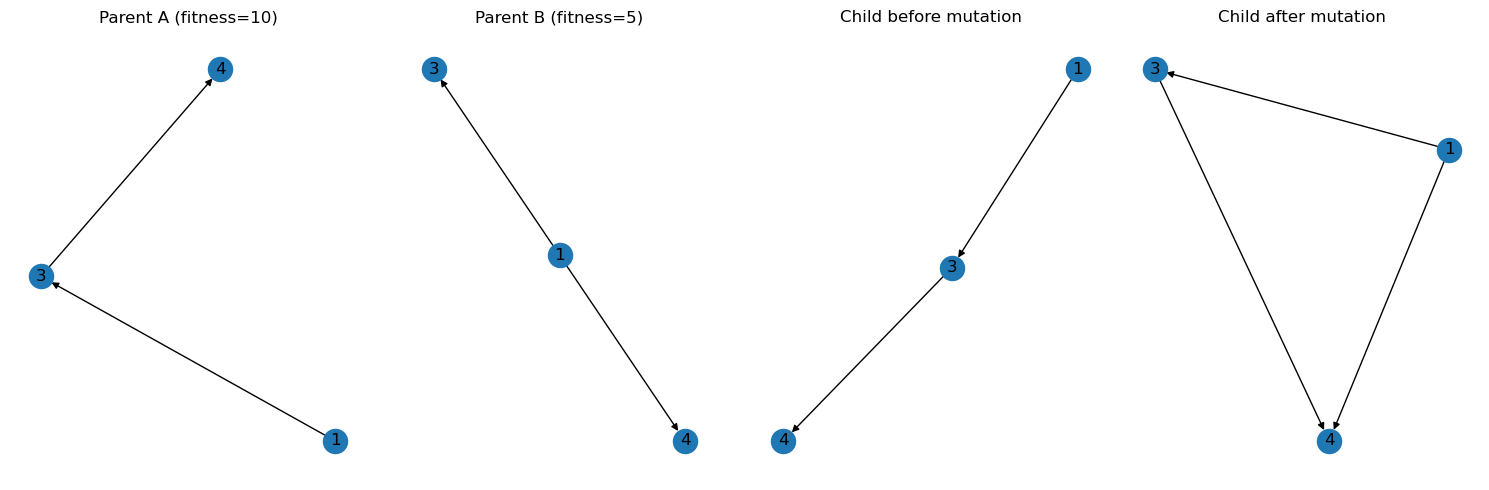

In [6]:
# nodes
node_1 = NodeGene(id=1, layer=0, activation='sigmoid', bias=0) # input
node_2 = NodeGene(id=2, layer=0, activation='sigmoid', bias=0) # input
node_3 = NodeGene(id=3, layer=1, activation='sigmoid', bias=0) # hidden
node_4 = NodeGene(id=4, layer=2, activation='sigmoid', bias=0) # output

# create connections for parent A
conn_a1 = NodeConnection(id=1, output_node_id=3, input_node_id=1, 
                        weight=0.87, enabled=True, innovation=1)
conn_a2 = NodeConnection(id=2, output_node_id=4, input_node_id=3, 
                        weight=0.5, enabled=True, innovation=2)

# create connections for parent B  
conn_b1 = NodeConnection(id=1, output_node_id=3, input_node_id=1, 
                        weight=0.5, enabled=True, innovation=1)
conn_b3 = NodeConnection(id=3, output_node_id=4, input_node_id=1, 
                        weight=0.5, enabled=True, innovation=3)

# build genomes
parent_a = Genome(nodes=[node_1, node_2, node_3, node_4], 
                connections=[conn_a1, conn_a2])
parent_a.fitness = 10

parent_b = Genome(nodes=[node_1, node_2, node_3], 
                connections=[conn_b1, conn_b3])
parent_b.fitness = 5

# init counter
innov = InnovationCounter(
    global_innovations = 2, # start after existing innovations
    node_connection_innovations = {(1, 3): 1, (2, 3): 2}  # dict with existing connections
)

# print parents
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 4 columns

print_genome_state(parent_a, "Parent A (fitness=10)")
visualize_genome(parent_a, ax=axes[0])
axes[0].set_title("Parent A (fitness=10)")

print_genome_state(parent_b, "Parent B (fitness=5)")
visualize_genome(parent_b, ax=axes[1])
axes[1].set_title("Parent B (fitness=5)")

# create and print crossover
child = crossover(parent_a, parent_b)
print_genome_state(child, "Before Mutations")
visualize_genome(child, ax=axes[2])
axes[2].set_title("Child before mutation")

# mutate weights
mutate_weights(child, mutation_rate=1.0, perturbation_strength=0.3, reset_rate=0.1)
mutate_connections(child, innov)
print_genome_state(child, "After Mutations")
visualize_genome(child, ax=axes[3])
axes[3].set_title("Child after mutation")

plt.tight_layout()
plt.show()

## 5. Evolutionary loop (Phenotype construction)
apply crossover over generations of genomes until population fitness threshold is met

Core loop:
1. evaluation: forward pass and evaluate against fitness function
2. speciation: nodes with similar topologies are chosen to reproduce
3. selection: those with high fitness scores are selected to reproduce
4. reproduction: crossover and mutation across selected pairs

In [7]:
class EvolutionLoop:
    """
    track the fitness and innovation numbers for the entire population
    """
    def __init__(self, fitness_fn, innov):
        self.fitness_fn = fitness_fn
        self.innov = innov

    """
    sort genome based on input->hidden->output structure
    """
    def topological_sort(self, genome):
        # compute the in-degree of each node
        in_degree = {id: 0 for id in genome.nodes.keys()}
        for conn in genome.connections.values():
            if conn.enabled:
                in_degree[conn.output_node_id] += 1
        
        # create a processing queue of nodes with no incoming edges (fifo)
        queue = [nid for nid, deg in in_degree.items() if deg == 0]
        topo_order = []

        # process each node in order 
        while queue:
            curr_node = queue.pop(0)
            topo_order.append(curr_node)

            # check next node
            for conn in genome.connections.values():
                if conn.enabled and conn.input_node_id == curr_node:
                    out = conn.output_node_id # find the output node
                    in_degree[out] -= 1 # decrement the output node
                    if in_degree[out] == 0: # add to queue
                        queue.append(out)
        
        # check for cycles
        if len(topo_order) != len(genome.nodes):
            raise ValueError("Cycle detected")
        
        return topo_order
    
    """
    given an input state of the world, compute the resulting actions
    - genome: node structure
    - input_values: external node values fed into the network
    """
    def forward_pass(self, genome, input_values):
        # collect intermediate values of each node in the network
        node_values = {}

        # map input values to input nodes
        for nid, val in input_values.items():
            if nid in genome.nodes:  # only process nodes that exist in this genome
                node_values[nid] = val
        
        # topological sort of nodes
        ordered_nodes = self.topological_sort(genome)

        # process each node in the network
        for nid in ordered_nodes:
            # skip all input values and nodes
            if nid in input_values and genome.nodes[nid].layer == 0:
                continue
        
            # incoming_sum = bias + Σ (source_value × weight)
            incoming_sum = genome.nodes[nid].bias
            for conn in genome.connections.values():
                if conn.enabled and conn.output_node_id == nid:
                    source_value = node_values[conn.input_node_id]
                    incoming_sum += source_value * conn.weight
            
            # apply activation function to sum (sigmoid)
            node_values[nid] = 1 / (1 + math.exp(-incoming_sum))

        # return output nodes from the full pass
        return [
            node_values[nid] for nid in node_values
            if nid in genome.nodes and genome.nodes[nid].layer == 2 
        ]

    """
    compute fitness based on the lanchester square equation
    """
    # def calculate_fitness(genome, obs):

# test
fitness_fn = None
innov_counter = innov  # use existing innov from earlier cell
loop = EvolutionLoop(fitness_fn, innov_counter)
order = loop.topological_sort(child)
input_values = {1: 0.6}  # only node 1 is input in child genome
output = loop.forward_pass(child, input_values)
print("Node values:", output)

Node values: [0.6651321420679847]


## 6. test simulation

In [8]:
from environment import WargameEnv
from game import Game

env = WargameEnv()
viz = Game(env)

# loop 100 times
for step in range(100):
    obs = env.get_observation() # get current state
    action = loop.forward_pass(child, obs)
    env.step(action) # updates world based on action
    viz.render()
